In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/MyDrive/05 github/recsys_key_papers_implementation/NCF/src/")

# Neural Collaborative Filtering

## 1. Dataset: Movie lens

- data description: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt
- Reference: https://doheelab.github.io/recommender-system/ncf_mlp/

In [19]:
import time
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

data_dir = 'dataset/'

In [4]:
train_df = pd.read_csv(data_dir + "ml-1m.train.rating", sep='\t', header=None)
train_df.columns = ["userID", "itemID", "rating","timestamp"]
print(len(train_df))
train_df.head()

994169


,userID,itemID,rating,timestamp
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


- 해당 연구에서는 user-item interaction만 사용 (rating 불필요)

In [5]:
test_df = pd.read_csv(data_dir + "ml-1m.test.negative", sep='\t', header=None)
print(len(test_df))
test_df.head()

6040


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,"(0,25)",1064,174,2791,3373,269,2678,1902,3641,1216,...,2854,3067,58,2551,2333,2688,3703,1300,1924,3118
1,"(1,133)",1072,3154,3368,3644,549,1810,937,1514,1713,...,1535,341,3525,1429,2225,1628,2061,469,3056,2553
2,"(2,207)",2216,209,2347,3,1652,3397,383,2905,2284,...,953,865,813,1353,2945,2580,2989,2790,2879,2481
3,"(3,208)",3023,1489,1916,1706,1221,1191,2671,81,2483,...,3347,1707,2901,2767,2167,1921,247,1618,2016,2323
4,"(4,222)",1794,3535,108,593,466,2048,854,1378,1301,...,2490,1332,2526,2804,2027,833,176,463,2851,2453


- negative sampling data

In [6]:
def load_all():
    train_df = pd.read_csv(data_dir + "ml-1m.train.rating", sep='\t', header=None)
    train_df.columns = ["userID", "itemID", "rating","timestamp"]
    train_df = train_df[["userID","itemID"]]

    user_num = train_df["userID"].max() + 1
    item_num = train_df["itemID"].max() + 1

    # dok matrix 생성 (Dictionary Of Key)
    train_df_list = train_df.values.tolist()
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in train_df_list:
        train_mat[x[0], x[1]] = 1.0

    test_df = pd.read_csv(data_dir + "ml-1m.test.negative", sep='\t', header=None)
    test_df = test_df.values.tolist()
    test_df_list=[]
    for arr in test_df:
        _user,_item = eval(arr[0])
        test_df_list.append([_user,_item])
        for j in arr[1:]:
            test_df_list.append([_user,int(j)])

    return train_df_list, test_df_list, user_num, item_num, train_mat

# prepare dataset
train_data, test_data, user_num, item_num, train_mat = load_all()

In [7]:
print("user:", user_num)
print("iser:", item_num)

user: 6040
iser: 3706


In [8]:
print(train_mat)

  (0, 32)	1.0
  (0, 34)	1.0
  (0, 4)	1.0
  (0, 35)	1.0
  (0, 30)	1.0
  (0, 29)	1.0
  (0, 33)	1.0
  (0, 40)	1.0
  (0, 10)	1.0
  (0, 16)	1.0
  (0, 23)	1.0
  (0, 28)	1.0
  (0, 12)	1.0
  (0, 8)	1.0
  (0, 5)	1.0
  (0, 20)	1.0
  (0, 46)	1.0
  (0, 15)	1.0
  (0, 50)	1.0
  (0, 49)	1.0
  (0, 13)	1.0
  (0, 1)	1.0
  (0, 52)	1.0
  (0, 38)	1.0
  (0, 19)	1.0
  :	:
  (6039, 309)	1.0
  (6039, 1951)	1.0
  (6039, 51)	1.0
  (6039, 104)	1.0
  (6039, 134)	1.0
  (6039, 2585)	1.0
  (6039, 3042)	1.0
  (6039, 2471)	1.0
  (6039, 167)	1.0
  (6039, 559)	1.0
  (6039, 23)	1.0
  (6039, 420)	1.0
  (6039, 3412)	1.0
  (6039, 9)	1.0
  (6039, 346)	1.0
  (6039, 1234)	1.0
  (6039, 1615)	1.0
  (6039, 2748)	1.0
  (6039, 1551)	1.0
  (6039, 2517)	1.0
  (6039, 1092)	1.0
  (6039, 41)	1.0
  (6039, 128)	1.0
  (6039, 323)	1.0
  (6039, 669)	1.0


## 2. DataLoader

In [9]:
args = {
    "batch_size": 256,
    "dropout": 0.0,
    "epochs": 20,
    "factor_num": 32,
    "gpu": "0",
    "lr": 0.001,
    "num_layers": 3,
    "num_ng": 4,
    "out": True,
    "test_num_ng": 99,
    "top_k": 10,
}

In [10]:
class NCFData(data.Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(NCFData, self).__init__()
        """ Note that the labels are only useful when training, we thus
			add them in the ng_sample() function.
		"""
        # self.features_ps = [[0, 121], [0, 199], [1, 456],...]
        self.features_ps = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.labels = [0] * len(features)

    def set_ng_sample(self):
        assert self.is_training, "no need to sampling when testing"

        # negative sample 더하기
        self.features_ng = []
        for x in self.features_ps:
            # user
            u = x[0]
            for _ in range(self.num_ng):
                j = np.random.randint(self.num_item)
                # train set에 있는 경우 다시 뽑기
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_ng.append([u, j])

        labels_ps = [1] * len(self.features_ps)
        labels_ng = [0] * len(self.features_ng)

        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng

    def __len__(self):
        return (self.num_ng + 1) * len(self.labels)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features_ps
        labels = self.labels_fill if self.is_training else self.labels

        user = features[idx][0]
        item = features[idx][1]
        label = labels[idx]
        return user, item, label

- `set_ng_sample`: negetive sampling 해주는 함수 (training set에만 적용)
- `label`: negative sample에 0을 할당
- `test_num_ng`: test set은 99+1 batch로 샘플링해서 metric에 사용(?)


In [11]:
def prepare_data(train_data, test_data, item_num, train_mat):

    # construct the train and test datasets
    # args = (features, num_item, train_mat=None, num_ng=0, is_training=None)
    train_dataset = NCFData(train_data, item_num, train_mat, args["num_ng"], True)
    test_dataset = NCFData(test_data, item_num, train_mat, 0, False)
    train_loader = data.DataLoader(
        train_dataset, batch_size=args["batch_size"], shuffle=True, num_workers=4
    )
    test_loader = data.DataLoader(
        test_dataset, batch_size=args["test_num_ng"] + 1, shuffle=False, num_workers=0
    )

    return train_loader, test_loader

train_loader, test_loader = prepare_data(train_data, test_data, item_num, train_mat)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 3. NCF Model

In [12]:
class NCF(nn.Module):
    def __init__(
        self, user_num, item_num, factor_num, num_layers, dropout, model,
    ):
        super(NCF, self).__init__()
        """
		user_num: number of users;
		item_num: number of items;
		factor_num: number of predictive factors;
		num_layers: the number of layers in MLP model;
		dropout: dropout rate between fully connected layers;
		model: 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre';
		"""
        self.dropout = dropout
        self.model = model

        # 임베딩 저장공간 확보; (num_embeddings, embedding_dim)
        self.embed_user_MLP = nn.Embedding(
            user_num, factor_num * (2 ** (num_layers - 1))
        )
        self.embed_item_MLP = nn.Embedding(
            item_num, factor_num * (2 ** (num_layers - 1))
        )

        MLP_modules = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            MLP_modules.append(nn.Dropout(p=self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size // 2))
            MLP_modules.append(nn.ReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)
        predict_size = factor_num
        self.predict_layer = nn.Linear(predict_size, 1)
        self._init_weight_()

    def _init_weight_(self):
        # weight 초기화
        nn.init.normal_(self.embed_user_MLP.weight, std=0.01)
        nn.init.normal_(self.embed_item_MLP.weight, std=0.01)
        for m in self.MLP_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        nn.init.kaiming_uniform_(self.predict_layer.weight, a=1, nonlinearity="sigmoid")

        # bias 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user, item):
        embed_user_MLP = self.embed_user_MLP(user)
        embed_item_MLP = self.embed_item_MLP(item)
        # 임베딩 벡터 합치기
        interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
        output_MLP = self.MLP_layers(interaction)
        concat = output_MLP

        # 예측하기
        prediction = self.predict_layer(concat)
        return prediction.view(-1)

In [16]:
def create_model(user_num, item_num, args):
    model = NCF(
        user_num,
        item_num,
        args["factor_num"],
        args["num_layers"],
        args["dropout"],
        'MLP',
    )
    model.cuda()
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])
    return model, loss_function, optimizer

# 모델 생성하기
model, loss_function, optimizer = create_model(user_num, item_num, args)

# 4. Metric

In [17]:
def hit(gt_item, pred_items):
    if gt_item in pred_items:
        return 1
    return 0


def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index + 2))
    return 0


def metrics(model, test_loader, top_k):
    HR, NDCG = [], []

    for user, item, _ in test_loader:
        user = user.cuda()
        item = item.cuda()

        predictions = model(user, item)
        # 가장 높은 top_k개 선택
        _, indices = torch.topk(predictions, top_k)
        # 해당 상품 index 선택
        recommends = torch.take(item, indices).cpu().numpy().tolist()
        # 정답값 선택
        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG)

# 5. Training

In [18]:
loss_ls = []
hr_ls = []
ndcg_ls = []

count, best_hr = 0, 0
#writer = SummaryWriter()  # for visualization
for epoch in range(args["epochs"]):
    model.train()  # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.set_ng_sample()

    for user, item, label in train_loader:
        user = user.cuda()
        item = item.cuda()
        label = label.float().cuda()

        # gradient 초기화
        model.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        loss_ls.append((count,loss.item()))
        #writer.add_scalar("data/loss", loss.item(), count)
        count += 1

    model.eval()
    HR, NDCG = metrics(model, test_loader, args["top_k"])
    hr_ls.append((epoch, HR))
    ndcg_ls.append((epoch, NDCG))

    elapsed_time = time.time() - start_time
    print(
        "The time elapse of epoch {:03d}".format(epoch)
        + " is: "
        + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
    )
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        # if args["out"]:
        #     if not os.path.exists(config["model_path"]):
        #         os.mkdir(config["model_path"])
        #     torch.save(
        #         model, "{}{}.pth".format(config["model_path"], config["model"])
        #     )

print(
    "End. Best epoch {:03d}: HR = {:.3f}, NDCG = {:.3f}".format(
        best_epoch, best_hr, best_ndcg
    )
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The time elapse of epoch 000 is: 00: 02: 10
HR: 0.555	NDCG: 0.310
The time elapse of epoch 001 is: 00: 02: 06
HR: 0.611	NDCG: 0.348
The time elapse of epoch 002 is: 00: 02: 05
HR: 0.645	NDCG: 0.375
The time elapse of epoch 003 is: 00: 02: 08
HR: 0.659	NDCG: 0.386
The time elapse of epoch 004 is: 00: 02: 03
HR: 0.664	NDCG: 0.392
The time elapse of epoch 005 is: 00: 02: 05
HR: 0.675	NDCG: 0.399
The time elapse of epoch 006 is: 00: 02: 05
HR: 0.676	NDCG: 0.403
The time elapse of epoch 007 is: 00: 02: 06
HR: 0.681	NDCG: 0.407
The time elapse of epoch 008 is: 00: 02: 04
HR: 0.685	NDCG: 0.411
The time elapse of epoch 009 is: 00: 02: 07
HR: 0.684	NDCG: 0.411
The time elapse of epoch 010 is: 00: 02: 06
HR: 0.688	NDCG: 0.418
The time elapse of epoch 011 is: 00: 02: 06
HR: 0.685	NDCG: 0.415
The time elapse of epoch 012 is: 00: 02: 06
HR: 0.690	NDCG: 0.418
The time elapse of epoch 013 is: 00: 02: 05
HR: 0.691	NDCG: 0.415
The time elapse of epoch 014 is: 00: 02: 07
HR: 0.681	NDCG: 0.411
The time e

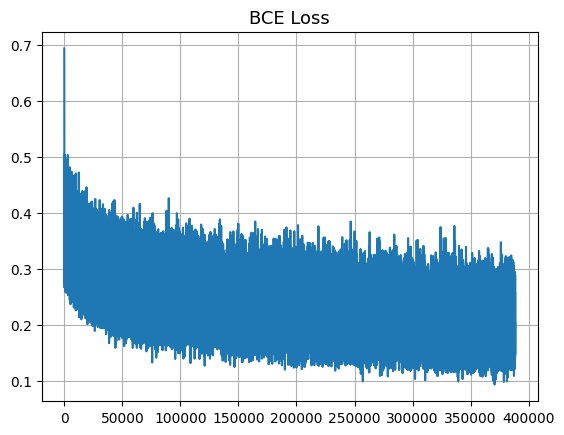

In [27]:
loss_ls_ar = np.array(loss_ls)
plt.plot(loss_ls_ar[:,0], loss_ls_ar[:,1])
plt.title("BCE Loss", fontsize=13)
plt.grid()
plt.show()

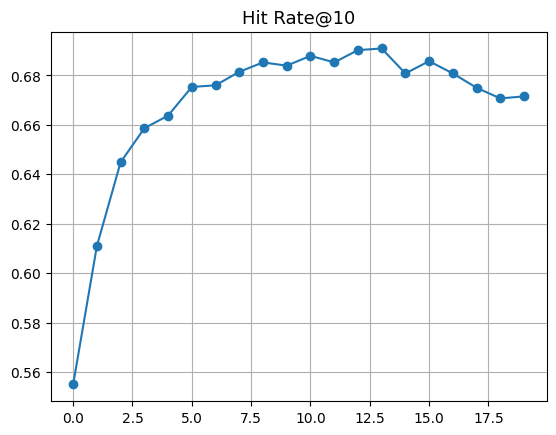

In [32]:
hr_ls_ar = np.array(hr_ls)
plt.plot(hr_ls_ar[:,0], hr_ls_ar[:,1], "o-")
plt.title("Hit Rate@"+str(args["top_k"]), fontsize=13)
plt.grid()
plt.show()

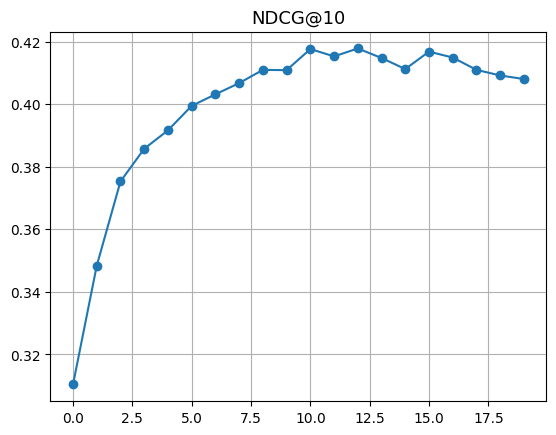

In [33]:
ndcg_ls_ar = np.array(ndcg_ls)
plt.plot(ndcg_ls_ar[:,0], ndcg_ls_ar[:,1], "o-")
plt.title("NDCG@"+str(args["top_k"]), fontsize=13)
plt.grid()
plt.show()